# Deep Learning Assignment 4 — RNN/LSTM/GRU (Colab, GPU)

Instructions:
- In Colab: Runtime → Change runtime type → Hardware accelerator: GPU.

- Get the dataset into Colab in one of two ways:
  - Option A (recommended): Mount Google Drive and point to the folder that contains `Hand_writing_Data` and `CV_DATA`.
  - Option B: Upload a zip containing the same folder structure.

- Run cells top-to-bottom. Outputs (plots and results) are saved under `/content/outputs`.


In [1]:
import torch, platform
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Python:', platform.python_version())
print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available(), '| device:', device)


Python: 3.12.12
PyTorch: 2.8.0+cu126
CUDA available: True | device: cuda


In [2]:
%pip install -q matplotlib numpy
import os, sys, json, math, glob, zipfile, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


## Data Setup — Option A (Google Drive)
Mount Drive, then set `DATA_BASE` to the folder that contains both `Hand_writing_Data` and `CV_DATA` (e.g., `/content/drive/MyDrive/Data_Assignment4/Data_Assignment4/Data_Assignment4`).


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# # TODO: Set this to the directory that contains Hand_writing_Data and CV_DATA
# DATA_BASE = '/content/drive/MyDrive/Data_Assignment4/Data_Assignment4/Data_Assignment4'  # <-- change me
# print('DATA_BASE:', DATA_BASE)
# assert os.path.exists(DATA_BASE), 'DATA_BASE does not exist. Update the path above.'
# print('Contains:', os.listdir(DATA_BASE))


## Data Setup — Option B (Upload Zip)
Upload a single zip that contains the top-level `Hand_writing_Data` and `CV_DATA` folders. This cell extracts to `/content/Uploaded_Assignment4` and sets `DATA_BASE` accordingly.
Skip this if you used Option A.


In [7]:
from google.colab import files
uploaded = files.upload()  # choose your zip
up_zip = next(iter(uploaded))
extract_dir = Path('/content/Uploaded_Assignment4')
extract_dir.mkdir(parents=True, exist_ok=True)
!unzip -q -o "$up_zip" -d "$extract_dir"
def locate_assignment_base(root):
    for r, d, f in os.walk(root):
        dset = set([x.lower() for x in d])
        if 'handwriting' in dset and 'cv' in dset:
            return r
    return None
DATA_BASE = locate_assignment_base(str(extract_dir))
assert DATA_BASE, 'Could not find Hand_writing_Data and CV_DATA in the uploaded zip'
print('DATA_BASE:', DATA_BASE)


Saving data.zip to data (1).zip
DATA_BASE: /content/Uploaded_Assignment4/data


## Prepare Local Data Folders
This extracts per-class zips into `/content/data/handwriting` and `/content/data/cv`. If already extracted, uses the existing structure.


In [12]:
from pathlib import Path
BASE = Path('/content')
DATA_DIR = BASE / 'data'
HW_DST = DATA_DIR / 'handwriting'
CV_DST = DATA_DIR / 'cv'
HW_DST.mkdir(parents=True, exist_ok=True)
CV_DST.mkdir(parents=True, exist_ok=True)
def locate_subdir(base: str, name: str):
    name_l = name.lower()
    for r, d, f in os.walk(base):
        if name_l in [x.lower() for x in d]:
            return os.path.join(r, name)
    return None
hw_src = locate_subdir(DATA_BASE, 'handwriting')
cv_src = locate_subdir(DATA_BASE, 'cv')
assert hw_src and cv_src, 'Could not locate Hand_writing_Data and CV_DATA under DATA_BASE'
print('Found:', hw_src)
print('Found:', cv_src)
import glob, zipfile
def extract_dir_of_zips(src_dir: str, dst_root: Path):
    zips = sorted(glob.glob(os.path.join(src_dir, '*.zip')))
    if zips:
        for z in zips:
            cls = Path(z).stem
            dest = dst_root / cls
            dest.mkdir(parents=True, exist_ok=True)
            with zipfile.ZipFile(z) as zf:
                zf.extractall(dest)
        return dst_root
    else:
        return Path(src_dir)
HW_ROOT = extract_dir_of_zips(hw_src, HW_DST)
CV_ROOT = extract_dir_of_zips(cv_src, CV_DST)
print('HW_ROOT:', HW_ROOT)
print('CV_ROOT:', CV_ROOT)
print('Handwriting classes:', [p.name for p in Path(HW_ROOT).iterdir() if p.is_dir()][:5])
print('CV classes:', [p.name for p in Path(CV_ROOT).iterdir() if p.is_dir()][:5])


Found: /content/Uploaded_Assignment4/data/handwriting
Found: /content/Uploaded_Assignment4/data/cv
HW_ROOT: /content/Uploaded_Assignment4/data/handwriting
CV_ROOT: /content/Uploaded_Assignment4/data/cv
Handwriting classes: ['dA', 'bA', 'chA', 'a', 'ai']
CV classes: ['tA', 'bhA', 'ba', 'ka', 'ni']


## Dataset and Collate (inline)


In [13]:
from __future__ import annotations

import os
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Optional, Sequence, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset


def _read_handwriting_file(path: Path) -> np.ndarray:
    # Each file: first number = count; remaining numbers = x,y pairs
    text = path.read_text(encoding="utf-8").strip()
    # Some files might have newlines; split on whitespace
    parts = text.split()
    if len(parts) < 3:
        raise ValueError(f"File {path} too short: {len(parts)} tokens")
    n_points = int(float(parts[0]))
    values = list(map(float, parts[1:]))
    if len(values) != n_points * 2:
        # Some files might include trailing values or formatting; truncate or pad if needed
        if len(values) > n_points * 2:
            values = values[: n_points * 2]
        else:
            # pad with last value if missing
            last = values[-1] if values else 0.0
            values = values + [last] * (n_points * 2 - len(values))
    arr = np.array(values, dtype=np.float32).reshape(n_points, 2)
    # Normalize per file to [0,1] for both coordinates
    # The data seems pre-normalized already, but we enforce it for safety.
    mins = arr.min(axis=0)
    maxs = arr.max(axis=0)
    denom = np.maximum(maxs - mins, 1e-6)
    norm = (arr - mins) / denom
    return norm


def _read_mfcc_file(path: Path) -> np.ndarray:
    # Each row: 39-dim vector, space separated scientific notation values
    rows: List[List[float]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            vec = [float(x) for x in line.split()]
            rows.append(vec)
    if not rows:
        raise ValueError(f"Empty MFCC file: {path}")
    arr = np.array(rows, dtype=np.float32)
    return arr


@dataclass
class SequenceSample:
    seq: torch.Tensor  # (T, F)
    label: int
    length: int


class HandwritingDataset(Dataset[SequenceSample]):
    """Handwritten character sequences dataset.

    Expected folder layout after unzip:
      data/handwriting/<cls>/<cls>/{train,dev}/*.txt
    """

    def __init__(
        self,
        root: Path,
        split: str,  # "train" or "dev" (treated as test)
        class_map: Optional[Dict[str, int]] = None,
        transform: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    ) -> None:
        self.root = Path(root)
        self.split = split
        self.transform = transform

        # Discover classes
        classes = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        if class_map is None:
            self.class_map = {c: i for i, c in enumerate(classes)}
        else:
            self.class_map = class_map

        self.samples: List[Tuple[Path, int]] = []
        for cls in classes:
            cls_idx = self.class_map[cls]
            # files under <root>/<cls>/<cls>/<split>/*.txt
            split_dir = self.root / cls / cls / split
            if not split_dir.exists():
                # Some zips may use uppercase Test/Train
                split_dir = self.root / cls / cls / split.capitalize()
            if not split_dir.exists():
                continue
            for f in sorted(split_dir.glob("*.txt")):
                self.samples.append((f, cls_idx))
        if not self.samples:
            raise FileNotFoundError(f"No samples found under {self.root} split={split}")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> SequenceSample:
        path, label = self.samples[idx]
        arr = _read_handwriting_file(path)
        if self.transform is not None:
            arr = self.transform(arr)
        seq = torch.from_numpy(arr)  # (T, 2)
        length = seq.shape[0]
        return SequenceSample(seq=seq, label=label, length=length)


class CVDataset(Dataset[SequenceSample]):
    """Consonant-Vowel MFCC sequences dataset.

    Expected folder layout after unzip:
      data/cv/<cls>/<cls>/{Train,Test}/*.mfcc
    """

    def __init__(
        self,
        root: Path,
        split: str,  # "Train" or "Test"
        class_map: Optional[Dict[str, int]] = None,
        transform: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        feature_normalizer: Optional[Tuple[np.ndarray, np.ndarray]] = None,
    ) -> None:
        self.root = Path(root)
        self.split = split
        self.transform = transform
        self.feature_normalizer = feature_normalizer  # (mean, std) over feature dim

        classes = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        if class_map is None:
            self.class_map = {c: i for i, c in enumerate(classes)}
        else:
            self.class_map = class_map

        self.samples: List[Tuple[Path, int]] = []
        for cls in classes:
            cls_idx = self.class_map[cls]
            split_dir = self.root / cls / cls / split
            if not split_dir.exists():
                split_dir = self.root / cls / cls / split.capitalize()
            if not split_dir.exists():
                continue
            for f in sorted(split_dir.glob("*.mfcc")):
                self.samples.append((f, cls_idx))
        if not self.samples:
            raise FileNotFoundError(f"No samples found under {self.root} split={split}")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> SequenceSample:
        path, label = self.samples[idx]
        arr = _read_mfcc_file(path)
        if self.feature_normalizer is not None:
            mean, std = self.feature_normalizer
            std_safe = np.where(std < 1e-6, 1.0, std)
            arr = (arr - mean) / std_safe
        if self.transform is not None:
            arr = self.transform(arr)
        seq = torch.from_numpy(arr)  # (T, 39)
        length = seq.shape[0]
        return SequenceSample(seq=seq, label=label, length=length)


def compute_feature_norm(dataset: CVDataset) -> Tuple[np.ndarray, np.ndarray]:
    """Compute per-feature mean/std across all frames of all sequences in the dataset."""
    sums = None
    sq_sums = None
    count = 0
    for i in range(len(dataset)):
        sample = dataset[i]
        x = sample.seq.numpy()  # (T, F)
        if sums is None:
            F = x.shape[1]
            sums = np.zeros((F,), dtype=np.float64)
            sq_sums = np.zeros((F,), dtype=np.float64)
        sums += x.sum(axis=0)
        sq_sums += (x * x).sum(axis=0)
        count += x.shape[0]
    mean = (sums / max(count, 1)).astype(np.float32)
    var = (sq_sums / max(count, 1) - mean.astype(np.float64) ** 2).astype(np.float32)
    std = np.sqrt(np.maximum(var, 0.0)).astype(np.float32)
    return mean, std


def pad_collate(batch: Sequence[SequenceSample]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Collate variable-length sequences by padding to the max length in batch.

    Returns:
      padded: (B, T_max, F)
      lengths: (B,) long
      labels: (B,) long
    """
    seqs = [b.seq for b in batch]
    lens = torch.tensor([b.length for b in batch], dtype=torch.long)
    labels = torch.tensor([b.label for b in batch], dtype=torch.long)
    # pad
    F = seqs[0].shape[1]
    T_max = int(max(x.shape[0] for x in seqs))
    padded = torch.zeros((len(seqs), T_max, F), dtype=seqs[0].dtype)
    for i, s in enumerate(seqs):
        padded[i, : s.shape[0]] = s
    return padded, lens, labels



## Model (RNN/LSTM/GRU)


In [14]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Literal, Tuple

import torch
from torch import nn


RNNKind = Literal["RNN", "LSTM", "GRU"]


@dataclass
class RNNConfig:
    input_size: int
    hidden_size: int = 64
    num_layers: int = 1
    rnn_type: RNNKind = "LSTM"
    dropout: float = 0.0
    bidirectional: bool = False
    num_classes: int = 5


class SequenceClassifier(nn.Module):
    def __init__(self, cfg: RNNConfig):
        super().__init__()
        self.cfg = cfg

        rnn_cls = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[cfg.rnn_type]
        self.rnn = rnn_cls(
            input_size=cfg.input_size,
            hidden_size=cfg.hidden_size,
            num_layers=cfg.num_layers,
            batch_first=True,
            dropout=cfg.dropout if cfg.num_layers > 1 else 0.0,
            bidirectional=cfg.bidirectional,
        )
        h_out = cfg.hidden_size * (2 if cfg.bidirectional else 1)
        self.head = nn.Sequential(
            nn.LayerNorm(h_out),
            nn.Linear(h_out, cfg.num_classes),
        )

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        # x: (B, T, F), lengths: (B,)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        outputs, hidden = self.rnn(packed)
        # Take the last hidden state from final layer
        if isinstance(hidden, tuple):
            h_n, c_n = hidden  # type: ignore
        else:
            h_n = hidden
        # h_n: (num_layers * num_directions, B, hidden_size)
        last = h_n[-1]  # (B, hidden_size) from top layer, last direction
        logits = self.head(last)
        return logits



## Training with Early Stopping (Δ loss < 1e-4)


In [15]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
def _accuracy_score(y_true: List[int], y_pred: List[int]) -> float:
    if not y_true:
        return 0.0
    correct = sum(int(a == b) for a, b in zip(y_true, y_pred))
    return correct / len(y_true)


def _confusion_matrix(y_true: List[int], y_pred: List[int]) -> np.ndarray:
    n = max(max(y_true, default=-1), max(y_pred, default=-1)) + 1
    cm = np.zeros((n, n), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm


@dataclass
class TrainResult:
    history: List[float]
    train_accuracy: float
    test_accuracy: float
    confusion: np.ndarray


def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer | None,
    device: torch.device,
) -> Tuple[float, float]:
    if optimizer is None:
        model.eval()
    else:
        model.train()
    total_loss = 0.0
    n = 0
    all_preds: List[int] = []
    all_labels: List[int] = []
    for xb, lens, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        lens = lens.to(device)
        if optimizer is not None:
            optimizer.zero_grad()
        logits = model(xb, lens)
        loss = criterion(logits, yb)
        if optimizer is not None:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        bs = yb.size(0)
        total_loss += loss.item() * bs
        n += bs
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy().tolist()
        all_preds.extend(preds)
        all_labels.extend(yb.detach().cpu().numpy().tolist())
    avg_loss = total_loss / max(n, 1)
    acc = _accuracy_score(all_labels, all_preds) if all_labels else 0.0
    return avg_loss, acc


def train_with_early_stopping(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
    lr: float = 1e-3,
    threshold: float = 1e-4,
    max_epochs: int = 200,
) -> TrainResult:
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history: List[float] = []
    prev_loss = float("inf")
    for epoch in range(1, max_epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device)
        history.append(train_loss)
        delta = abs(prev_loss - train_loss)
        prev_loss = train_loss
        # Early stopping criterion per assignment: diff between successive epochs < threshold
        if delta < threshold:
            break

    # Final evaluation on train and test
    criterion = nn.CrossEntropyLoss()
    train_loss, train_acc = run_epoch(model, train_loader, criterion, None, device)
    test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device)

    # Confusion matrix on test set
    all_preds: List[int] = []
    all_labels: List[int] = []
    model.eval()
    with torch.no_grad():
        for xb, lens, yb in test_loader:
            xb = xb.to(device)
            lens = lens.to(device)
            logits = model(xb, lens)
            preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy().tolist())
    conf = _confusion_matrix(all_labels, all_preds)

    return TrainResult(history=history, train_accuracy=train_acc, test_accuracy=test_acc, confusion=conf)


## Experiment Helpers and Plots


In [16]:
from dataclasses import dataclass
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

@dataclass
class ExperimentConfig:
    model_type: str
    hidden_size: int
    num_layers: int
    dropout: float
    lr: float

def plot_loss(history, out_path: Path, title: str):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(history)+1), history, marker='o')
    plt.xlabel('Epoch'); plt.ylabel('Average training loss'); plt.title(title)
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.savefig(out_path); plt.close()

def save_confusion_matrix(cm: np.ndarray, out_path: Path, class_names):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(int(cm[i,j])), ha='center', va='center', color='black')
    plt.tight_layout(); plt.savefig(out_path); plt.close()

def visualize_handwriting_samples(root: Path, out_dir: Path, per_class: int = 5):
    out_dir.mkdir(parents=True, exist_ok=True)
    ds = HandwritingDataset(root, split='train')
    class_names = [None]*len(ds.class_map)
    for name, idx in ds.class_map.items(): class_names[idx]=name
    for cls_name in class_names:
        train_dir = Path(root)/cls_name/cls_name/'train'
        if not train_dir.exists(): train_dir = Path(root)/cls_name/cls_name/'Train'
        files = sorted(list(train_dir.glob('*.txt')))[:per_class]
        for i, p in enumerate(files):
            arr = _read_handwriting_file(p)
            plt.figure(figsize=(3,3))
            plt.plot(arr[:,0], arr[:,1], marker='o', markersize=1, linewidth=1)
            plt.xlim(0,1); plt.ylim(0,1); plt.gca().invert_yaxis(); plt.title(f'{cls_name} sample {i+1}')
            plt.tight_layout(); plt.savefig(out_dir/f'{cls_name}_{i+1}.png', dpi=150); plt.close()

def run_handwriting_experiments(data_root: Path, out_root: Path, device: torch.device, exps):
    train_ds = HandwritingDataset(data_root, split='train')
    test_ds = HandwritingDataset(data_root, split='dev', class_map=train_ds.class_map)
    class_names = [None]*len(train_ds.class_map)
    for name, idx in train_ds.class_map.items(): class_names[idx]=name
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=pad_collate)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=pad_collate)
    results = {}
    for exp in exps:
        cfg = RNNConfig(input_size=2, hidden_size=exp.hidden_size, num_layers=exp.num_layers, rnn_type=exp.model_type, dropout=exp.dropout, bidirectional=False, num_classes=len(class_names))
        model = SequenceClassifier(cfg)
        tr = train_with_early_stopping(model, train_loader, test_loader, device, lr=exp.lr, threshold=1e-4, max_epochs=200)
        tag = f'{exp.model_type}_h{exp.hidden_size}_L{exp.num_layers}_d{exp.dropout}'
        plot_loss(tr.history, out_root/'handwriting'/f'loss_{tag}.png', f'Handwriting {tag}')
        save_confusion_matrix(tr.confusion, out_root/'handwriting'/f'cm_{tag}.png', class_names)
        results[tag] = {'train_accuracy': tr.train_accuracy, 'test_accuracy': tr.test_accuracy, 'history_len': len(tr.history)}
    (out_root/'handwriting').mkdir(parents=True, exist_ok=True)
    (out_root/'handwriting'/'results.json').write_text(json.dumps(results, indent=2), encoding='utf-8')
    return results

def run_cv_experiments(data_root: Path, out_root: Path, device: torch.device, exps):
    tmp_train = CVDataset(data_root, split='Train')
    mean, std = compute_feature_norm(tmp_train)
    train_ds = CVDataset(data_root, split='Train', class_map=tmp_train.class_map, feature_normalizer=(mean, std))
    test_ds = CVDataset(data_root, split='Test', class_map=tmp_train.class_map, feature_normalizer=(mean, std))
    class_names = [None]*len(train_ds.class_map)
    for name, idx in train_ds.class_map.items(): class_names[idx]=name
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=pad_collate)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=pad_collate)
    results = {}
    for exp in exps:
        cfg = RNNConfig(input_size=39, hidden_size=exp.hidden_size, num_layers=exp.num_layers, rnn_type=exp.model_type, dropout=exp.dropout, bidirectional=False, num_classes=len(class_names))
        model = SequenceClassifier(cfg)
        tr = train_with_early_stopping(model, train_loader, test_loader, device, lr=exp.lr, threshold=1e-4, max_epochs=200)
        tag = f'{exp.model_type}_h{exp.hidden_size}_L{exp.num_layers}_d{exp.dropout}'
        plot_loss(tr.history, out_root/'cv'/f'loss_{tag}.png', f'CV {tag}')
        save_confusion_matrix(tr.confusion, out_root/'cv'/f'cm_{tag}.png', class_names)
        results[tag] = {'train_accuracy': tr.train_accuracy, 'test_accuracy': tr.test_accuracy, 'history_len': len(tr.history)}
    (out_root/'cv').mkdir(parents=True, exist_ok=True)
    (out_root/'cv'/'results.json').write_text(json.dumps(results, indent=2), encoding='utf-8')
    return results


## Visualize Handwriting Samples (normalized)


In [17]:
OUT_ROOT = Path('/content/outputs')
OUT_ROOT.mkdir(parents=True, exist_ok=True)
print('Saving handwriting sample plots...')
visualize_handwriting_samples(HW_ROOT, OUT_ROOT / 'handwriting_samples', per_class=5)
print('Done. Files in:', OUT_ROOT / 'handwriting_samples')
print(sorted([p.name for p in (OUT_ROOT / 'handwriting_samples').glob('*.png')])[:10])


Saving handwriting sample plots...
Done. Files in: /content/outputs/handwriting_samples
['a_1.png', 'a_2.png', 'a_3.png', 'a_4.png', 'a_5.png', 'ai_1.png', 'ai_2.png', 'ai_3.png', 'ai_4.png', 'ai_5.png']


## Run Experiments (Handwriting + CV)
Adjust the grids to explore more settings.


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
hw_exps = [
    ExperimentConfig(model_type='RNN', hidden_size=64, num_layers=1, dropout=0.0, lr=1e-3),
    ExperimentConfig(model_type='LSTM', hidden_size=64, num_layers=1, dropout=0.0, lr=1e-3),
]
cv_exps = [
    ExperimentConfig(model_type='RNN', hidden_size=128, num_layers=1, dropout=0.0, lr=1e-3),
    ExperimentConfig(model_type='LSTM', hidden_size=128, num_layers=1, dropout=0.0, lr=1e-3),
]
print('Running handwriting experiments...')
hw_results = run_handwriting_experiments(HW_ROOT, OUT_ROOT, device, hw_exps)
print(json.dumps(hw_results, indent=2))
print('Running CV experiments...')
cv_results = run_cv_experiments(CV_ROOT, OUT_ROOT, device, cv_exps)
print(json.dumps(cv_results, indent=2))


Device: cuda
Running handwriting experiments...
{
  "RNN_h64_L1_d0.0": {
    "train_accuracy": 0.8434782608695652,
    "test_accuracy": 0.85,
    "history_len": 200
  },
  "LSTM_h64_L1_d0.0": {
    "train_accuracy": 0.8695652173913043,
    "test_accuracy": 0.88,
    "history_len": 56
  }
}
Running CV experiments...
{
  "RNN_h128_L1_d0.0": {
    "train_accuracy": 0.9877049180327869,
    "test_accuracy": 0.8879781420765027,
    "history_len": 42
  },
  "LSTM_h128_L1_d0.0": {
    "train_accuracy": 1.0,
    "test_accuracy": 0.9234972677595629,
    "history_len": 25
  }
}


## Display Saved Plots


Handwriting loss plots:


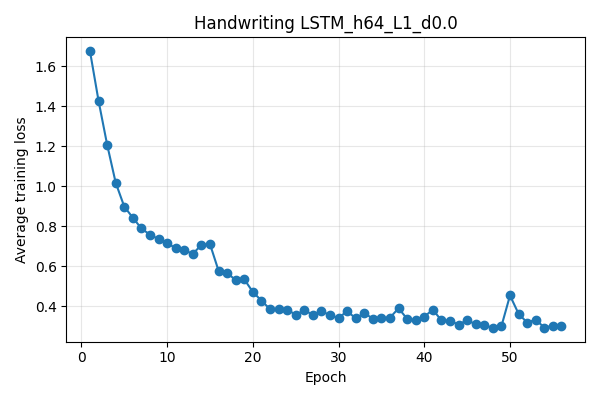

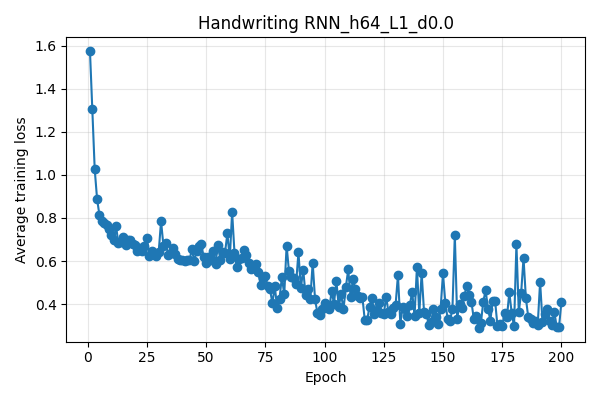


Handwriting confusion matrices:


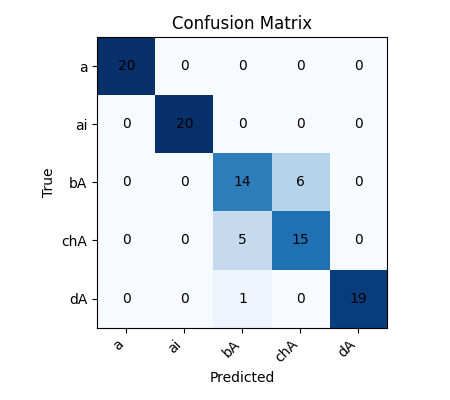

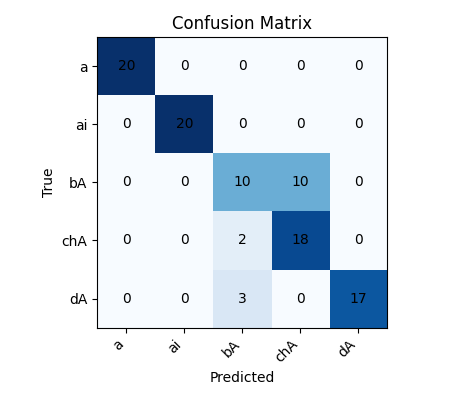


CV loss plots:


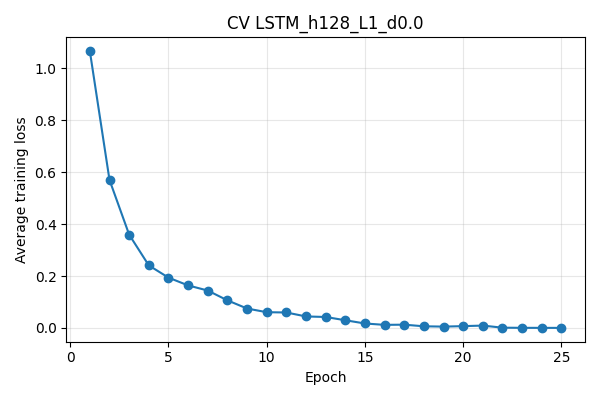

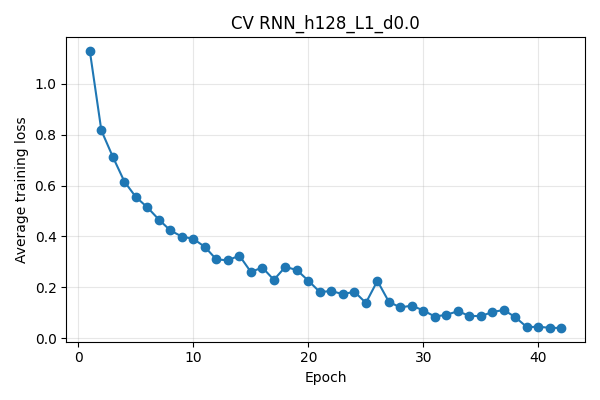


CV confusion matrices:


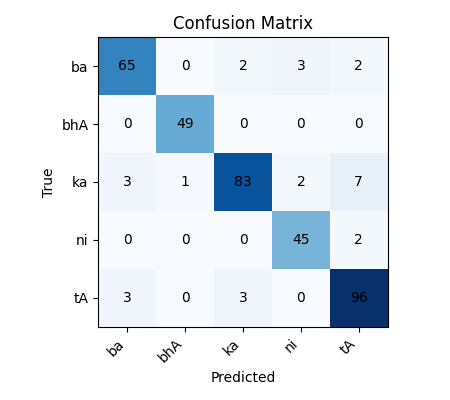

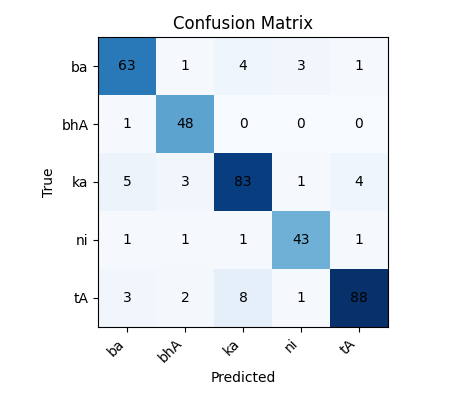

In [20]:
from IPython.display import Image, display
print('Handwriting loss plots:')
for p in sorted((OUT_ROOT/'handwriting').glob('loss_*.png')): display(Image(filename=str(p)))
print('\nHandwriting confusion matrices:')
for p in sorted((OUT_ROOT/'handwriting').glob('cm_*.png')): display(Image(filename=str(p)))
print('\nCV loss plots:')
for p in sorted((OUT_ROOT/'cv').glob('loss_*.png')): display(Image(filename=str(p)))
print('\nCV confusion matrices:')
for p in sorted((OUT_ROOT/'cv').glob('cm_*.png')): display(Image(filename=str(p)))

## Download Outputs (optional)
Zips the `/content/outputs` directory for download.


In [21]:
import shutil
from google.colab import files
zip_path = shutil.make_archive('/content/outputs', 'zip', '/content/outputs')
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>